In [74]:
%matplotlib inline

In [220]:
import tensorflow as tf
import numpy as np
import sys
import pandas as pd
from matplotlib import pyplot as plt


class TF_Reporter():
    
    def __init__(self, keys):
        self.initialize(keys)
        
    def initialize(self, keys):
        self.log_df = pd.DataFrame({key: [] for key in keys})
        self.keys = self.log_df.columns
        self.interesting = ",".join(self.log_df.columns)
        self.iter_count = 0
        
    def run_session(self, sess, feed_dict):
        
        log_df = self.log_df
        
        values = sess.run(eval(self.interesting),
                          feed_dict=feed_dict)
        
        self.recent_log = pd.Series(values, index=self.keys)
        log_df.append([self.recent_log])
        
        self.iter_count += 1
        
    def trace101(self, *args, one_line_text=""):
        
        iter_count = self.iter_count
        deco = ["-", "\\", "|", "/"][iter_count%4]
        
        one_line_text = "Iter: % 6d"%iter_count
        for arg in args:
            one_line_text += " %s %s: %0.9f"%(
                deco, arg, self.recent_log[arg]
            )

        sys.stdout.write("\r%s"%one_line_text)

In [221]:
g = tf.Graph()
with g.as_default():
    
    tf.set_random_seed(0)
    
    X = tf.placeholder(dtype=tf.float32, shape=[None, 2])
    y = tf.placeholder(dtype=tf.float32, shape=[None])
    
    L = tf.contrib.layers.fully_connected(
        X, 2, activation_fn=tf.sigmoid
    )
    
    raw_output = tf.contrib.layers.fully_connected(
        L, 1, activation_fn=tf.sigmoid
    )
    output = tf.squeeze(raw_output)
    
    loss = tf.losses.mean_squared_error(y, output)
    learn = tf.train.AdamOptimizer().minimize(loss)
    
    pred_y = tf.round(output)
    
    initializer = tf.global_variables_initializer()

Iter:   2794 | loss: 0.158895835

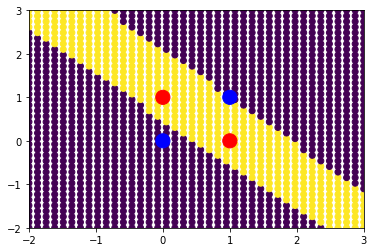

In [222]:
train_X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
train_y = np.array([v[0]^v[1] for v in train_X])

reporter = TF_Reporter(["learn", "loss", "pred_y"])


sess = tf.Session(graph=g)
sess.run(initializer)

while True:
    feed_dict = {X: train_X, y: train_y}
    reporter.run_session(sess, feed_dict)
    reporter.trace101("loss")
    curr_pred_y = reporter.recent_log["pred_y"]
    if np.all(curr_pred_y == train_y):
        break
        

pts = np.linspace(-2, 3, 40)
pts = np.array([[x_pt, y_pt] for x_pt in pts for y_pt in pts])
pred = [sess.run(pred_y, feed_dict={X: pt.reshape(1, 2)})
        for pt in pts]

plt.scatter(pts[:, 0], pts[:, 1], c=[v for v in pred])
plt.scatter(train_X[:, 0], train_X[:, 1],
            c=["r" if v else "b" for v in train_y],
            s=200)
plt.axis([-2, 3, -2, 3])
plt.show()


sess.close()